In [ ]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model,Sequential
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
(X_train,_),(_,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


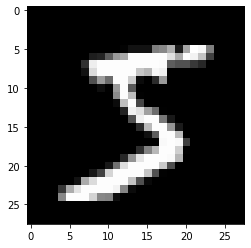

In [ ]:
plt.imshow(X_train[0],cmap='gray')
plt.show()

In [ ]:
X_train = (X_train.astype('float32') - 127.5)/127.5
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


In [ ]:
print(X_train.shape)

(60000, 28, 28)


In [ ]:
Total_epochs = 50
batch_size = 256
No_of_batches = int(X_train.shape[0]/batch_size)
half_batch = 128
Noise_dim = 100
adam = Adam(lr=2e-4,beta_1=0.5)

In [ ]:
generator = Sequential()
generator.add(Dense(256,input_shape=(Noise_dim,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 784)             

In [ ]:
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)               

In [ ]:
discriminator.trainable = False
gan_input = Input(shape=(Noise_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [ ]:
X_train = X_train.reshape((-1,784))
print(X_train.shape)

(60000, 784)


In [ ]:
for epoch in range(Total_epochs):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for steps in range(No_of_batches):

    idx = np.random.randint(0,X_train.shape[0],half_batch)
    real_images = X_train[idx]

    noise = np.random.normal(0,1,size=(half_batch,Noise_dim))
    fake_images = generator.predict(noise)

    real_y = np.ones((half_batch,1))*0.9
    fake_y = np.zeros((half_batch,1))

    d_loss_real = discriminator.train_on_batch(real_images,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images,fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    epoch_d_loss += d_loss

    noise = np.random.normal(0,1,size=(batch_size,Noise_dim))
    ground_truth_y = np.ones((batch_size,1))
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss += g_loss

  print("epoch = {} ds_loss = {} g_loss = {}".format(epoch+1,epoch_d_loss/No_of_batches,epoch_g_loss/No_of_batches))

  if(epoch+1)%5 == 0:
    generator.save("model_gan/gen_{}".format(epoch+1))

epoch = 1 ds_loss = 0.6604078023606895 g_loss = 1.1915979996705666
epoch = 2 ds_loss = 0.5839220421054424 g_loss = 1.494670356440748
epoch = 3 ds_loss = 0.5577344118784635 g_loss = 1.5533107075935755
epoch = 4 ds_loss = 0.5307551886026676 g_loss = 1.6799198063010843
epoch = 5 ds_loss = 0.5308642561873819 g_loss = 1.630619022071871
INFO:tensorflow:Assets written to: model_gan/gen_5/assets
epoch = 6 ds_loss = 0.5412083063752223 g_loss = 1.5301112675259256
epoch = 7 ds_loss = 0.5459079536744672 g_loss = 1.4883379615270174
epoch = 8 ds_loss = 0.5721802165747708 g_loss = 1.379599594662332
epoch = 9 ds_loss = 0.6045259591351207 g_loss = 1.2548856139183044
epoch = 10 ds_loss = 0.6181322876841594 g_loss = 1.170840808469006
INFO:tensorflow:Assets written to: model_gan/gen_10/assets
epoch = 11 ds_loss = 0.6171154568337986 g_loss = 1.1663687494066026
epoch = 12 ds_loss = 0.6119927455726851 g_loss = 1.187483894519317
epoch = 13 ds_loss = 0.6127678151441436 g_loss = 1.174108266321003
epoch = 14 ds_

In [ ]:
def save_imgs(sample=100):
  noise = np.random.normal(0,1,size=(sample,Noise_dim))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape((sample,28,28))

  plt.figure(figsize=(10,10))
  for i in range(sample):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('gan.png')
  plt.show()


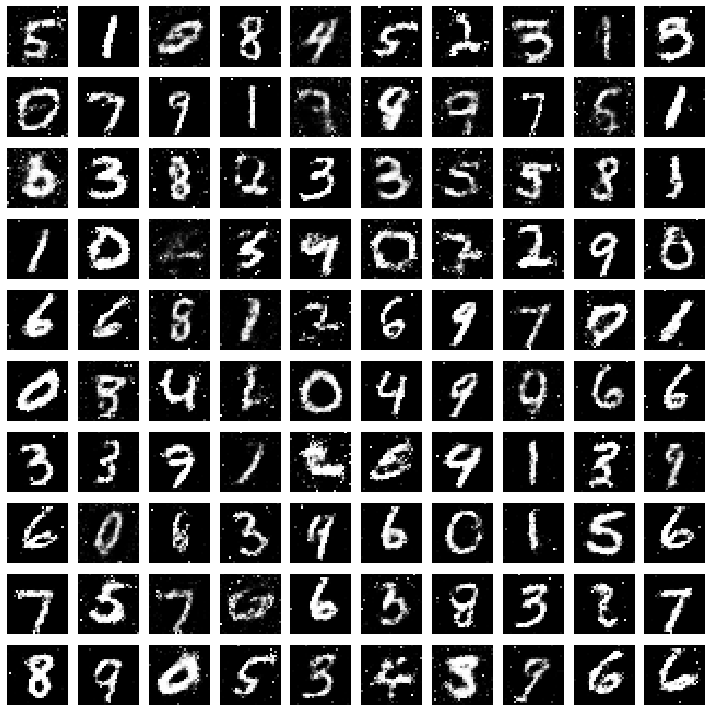

In [ ]:
save_imgs()

In [ ]:
!mkdir('images')

/bin/bash: -c: line 0: syntax error near unexpected token `'images''
/bin/bash: -c: line 0: `mkdir('images')'


DC GAN's

In [ ]:
X_train = X_train.reshape((*X_train.shape,1))

In [ ]:
print(X_train.shape)

(60000, 28, 28, 1)


In [ ]:
X_train = (X_train.astype('float32') - 127.5)/127.5
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


In [ ]:
Total_epochs = 50
batch_size = 256
No_of_batches = int(X_train.shape[0]/batch_size)
half_batch = 128
Noise_dim = 100
adam = Adam(lr=2e-4,beta_1=0.5)

In [ ]:
# generator Model

generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(Noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=(5,5),padding='same',activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer='adam')
generator.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)       

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [ ]:
discriminator.trainable = False
gan_input = Input(shape=(Noise_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [ ]:
for epoch in range(Total_epochs):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for steps in range(No_of_batches):

    idx = np.random.randint(0,X_train.shape[0],half_batch)
    real_images = X_train[idx]

    noise = np.random.normal(0,1,size=(half_batch,Noise_dim))
    fake_images = generator.predict(noise)

    real_y = np.ones((half_batch,1))*0.9
    fake_y = np.zeros((half_batch,1))

    d_loss_real = discriminator.train_on_batch(real_images,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images,fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    epoch_d_loss += d_loss

    noise = np.random.normal(0,1,size=(batch_size,Noise_dim))
    ground_truth_y = np.ones((batch_size,1))
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss += g_loss

  print("epoch = {} ds_loss = {} g_loss = {}".format(epoch+1,epoch_d_loss/No_of_batches,epoch_g_loss/No_of_batches))

  if(epoch+1)%5 == 0:
    generator.save("model/gen_{}".format(epoch+1))

epoch = 1 ds_loss = 0.3517379045787936 g_loss = 1.3742521182976217
epoch = 2 ds_loss = 0.5075794133301984 g_loss = 2.151038472978478
epoch = 3 ds_loss = 0.4863780950092607 g_loss = 1.993544098148998
epoch = 4 ds_loss = 0.5463084833234804 g_loss = 1.6451921289802616
epoch = 5 ds_loss = 0.5258707999546304 g_loss = 1.6318684582017426
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/gen_5/assets
epoch = 6 ds_loss = 0.5461693464690803 g_loss = 1.5784102749620748
epoch = 7 ds_loss = 0.5583101693126891 g_loss = 1.5346838302082486
epoch = 8 ds_loss = 0.5619625056273917 g_loss = 1.4932548821481884
epoch = 9 ds_loss = 0.5643589696568302 g_loss = 1.4772824344471989
epoch = 10 ds_loss = 0.5650476635648654 g_loss = 1.4744147398532965
INFO:tensorflow:Assets written to: model/ge

In [ ]:
!mkdir model

In [ ]:
!ls

model  sample_data


In [ ]:
def save_imgs(sample=100):
  noise = np.random.normal(0,1,size=(sample,Noise_dim))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape((sample,28,28))

  plt.figure(figsize=(10,10))
  for i in range(sample):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('gan.png')
  plt.show()


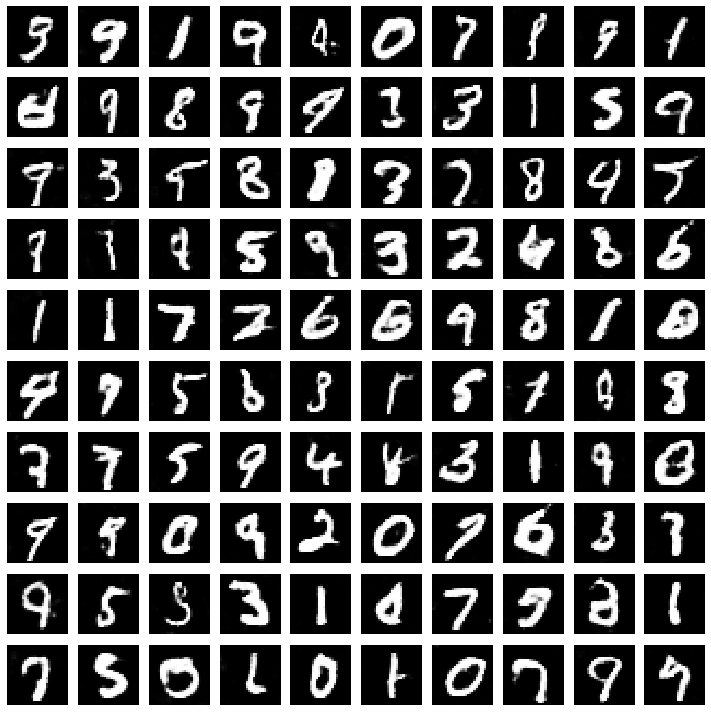

In [ ]:
save_imgs()

# Learnable Upsampling 

In [ ]:
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(Noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same',activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer='adam')
generator.summary()

NameError: ignored